# Overview

Using SOS data, identify days with mostly upvalley/downvalley winds,
and make a daily time series plot of wind-direction for each day that qualifies.

In [1]:
import pandas as pd
import numpy as np
import altair as alt
alt.data_transformers.enable('json')

from sublimpy import turbulence, tidy, utils
import matplotlib.pyplot as plt
import metpy.constants
import datetime as dt
import pytz

# Open data

## Open SOS Measurement Dataset

In [2]:
start_date = '20221130'
end_date = '20230619'
# tidy_data_fn = f'../paper1/tidy_df_{start_date}_{end_date}_noplanar_fit_clean.parquet'
tidy_data_fn = f'../paper1/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet'
# open files
tidy_df = pd.read_parquet(tidy_data_fn)
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:end_date].reset_index()

tidy_df = utils.modify_df_timezone(tidy_df, pytz.UTC, 'US/Mountain')

In [3]:
## Add combined blowing snow variable to dataset
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    (
        tidy_df.query("variable == 'SF_avg_1m_ue'")['value'].values + 
        tidy_df.query("variable == 'SF_avg_2m_ue'")['value'].values
    ), 
    'SF_avg_ue',
    'snow flux',
    1,
    'ue',
)


In [21]:
tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

In [32]:
print(len(tidy_df.time.unique()))
print()
print(len(tgrad_stable_times))
print(len(tgrad_neutral_times))
print(len(tgrad_unstable_times))

print()
print(len(ri_stable_times))
print(len(ri_neutral_times))
print(len(ri_unstable_times))


9696

7918
617
1122

2672
5630
1140


Text(0.5, 1.0, 'All data (n=9696)')

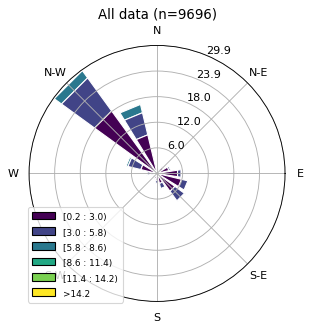

In [26]:
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm

ax = WindroseAxes.from_ax(figsize=(4, 4))
ax.bar(
    tidy_df.query(f"variable == 'dir_3m_c'")['value'], 
    tidy_df.query(f"variable == 'spd_3m_c'")['value'],
    normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
ax.set_title(f"All data (n={len(tidy_df.query(f"variable == 'dir_3m_c'")['value'])})")

Text(0.5, 1.0, 'Stable')

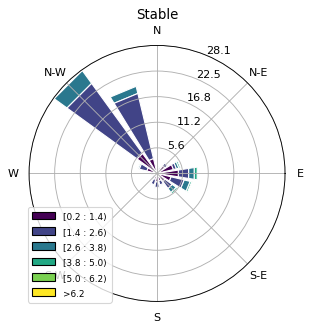

In [23]:
ax = WindroseAxes.from_ax(figsize=(4, 4))
ax.bar(
    tidy_df[tidy_df.time.isin(ri_stable_times)].query(f"variable == 'dir_3m_c'")['value'], 
    tidy_df[tidy_df.time.isin(ri_stable_times)].query(f"variable == 'spd_3m_c'")['value'],
    normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
ax.set_title('Stable')

Text(0.5, 1.0, 'Neutral')

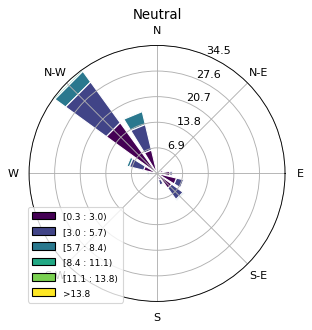

In [24]:
ax = WindroseAxes.from_ax(figsize=(4, 4))
ax.bar(
    tidy_df[tidy_df.time.isin(ri_neutral_times)].query(f"variable == 'dir_3m_c'")['value'], 
    tidy_df[tidy_df.time.isin(ri_neutral_times)].query(f"variable == 'spd_3m_c'")['value'],
    normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
ax.set_title('Neutral')

Text(0.5, 1.0, 'Unstable')

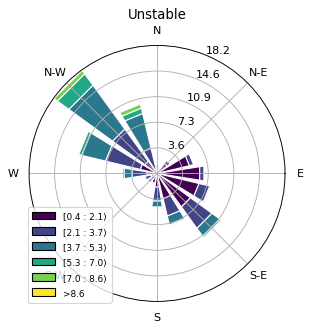

In [25]:
ax = WindroseAxes.from_ax(figsize=(4, 4))
ax.bar(
    tidy_df[tidy_df.time.isin(ri_unstable_times)].query(f"variable == 'dir_3m_c'")['value'], 
    tidy_df[tidy_df.time.isin(ri_unstable_times)].query(f"variable == 'spd_3m_c'")['value'],
    normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
ax.set_title('Unstable')

## Calibrate gas analyzer measurements

We calibrate by assuming that all gas analyzers have the same seasonal mean as the corresponding hygrometer measurement on the central tower (at a given height)

### With seasonal mean

In [ ]:
hygrometer_absolute_humidity_mean = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [ ]:
ec_absolute_humidity_mean = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()

In [ ]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value']].rename(columns={'value': 'truth'}),
    on='height'
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']
corrections_df

,variable,tower,height,value,truth,offset
0,h2o_10m_c,c,10.0,2.126837,2.077731,0.049106
1,h2o_10m_d,d,10.0,1.261839,2.077731,-0.815892
2,h2o_10m_ue,ue,10.0,1.088801,2.077731,-0.988930
3,h2o_10m_uw,uw,10.0,1.607363,2.077731,-0.470367
4,h2o_15m_c,c,15.0,1.954261,2.063564,-0.109303
5,h2o_1m_c,c,1.0,2.257756,2.108068,0.149688
6,h2o_1m_d,d,1.0,1.700445,2.108068,-0.407623
7,h2o_1m_ue,ue,1.0,1.310203,2.108068,-0.797865
8,h2o_1m_uw,uw,1.0,1.502313,2.108068,-0.605755
9,h2o_20m_c,c,20.0,0.934561,2.054133,-1.119572


Update dataset with corrections

In [ ]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
src

,time,variable,value,height,tower,measurement
94,2022-11-30 00:00:00,h2o_3m_uw,0.724031,3.0,uw,Water vapor density
189,2022-11-30 00:00:00,h2o_3m_c,0.913812,3.0,c,Water vapor density
219,2022-11-30 00:00:00,h2o_3m_ue,0.565408,3.0,ue,Water vapor density
221,2022-11-30 00:00:00,h2o_10m_ue,0.015322,10.0,ue,Water vapor density
337,2022-11-30 00:00:00,h2o_1m_uw,0.054356,1.0,uw,Water vapor density
...,...,...,...,...,...,...
6625843,2023-05-08 23:30:00,h2o_1m_ue,NaN,1.0,ue,Water vapor density
6625867,2023-05-08 23:30:00,h2o_3m_d,2.763570,3.0,d,Water vapor density
6625874,2023-05-08 23:30:00,h2o_1m_d,NaN,1.0,d,Water vapor density
6625880,2023-05-08 23:30:00,h2o_3m_ue,2.909646,3.0,ue,Water vapor density


In [ ]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [ ]:


alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_4391/1085128452.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [ ]:
for idx, row in corrections_df.iterrows():
    src = tidy_df.query(f"variable == '{row['variable']}'")
    src = src.assign(value = src.value - row['offset'])
    tidy_df = tidy_df[tidy_df.variable != row['variable']]
    tidy_df = pd.concat([tidy_df, src])

In [ ]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [9]:
winddir_3m_df = tidy_df.query(f"variable == 'dir_3m_c'")
winddir_3m_df = winddir_3m_df.assign(wind_is_alongvalley = 
    (
        ((winddir_3m_df.value > 292.5 - 10) & (winddir_3m_df.value < 337.5 + 10))
        |
        ((winddir_3m_df.value > 112.5 - 10) & (winddir_3m_df.value < 157.5 + 10))
    )
)
percent_wind_alongvalley = winddir_3m_df.set_index('time').groupby(pd.Grouper(freq='1440Min'))['wind_is_alongvalley'].sum()/48
dates_with_80percent_alongvalley = percent_wind_alongvalley[percent_wind_alongvalley > 0.7].index.to_series().dt.date
print(len(dates_with_80percent_alongvalley))

68


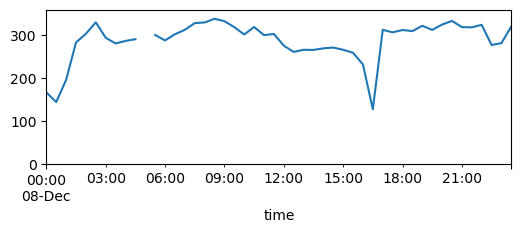

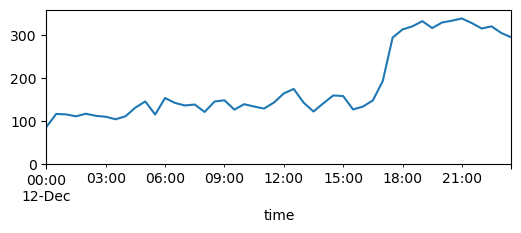

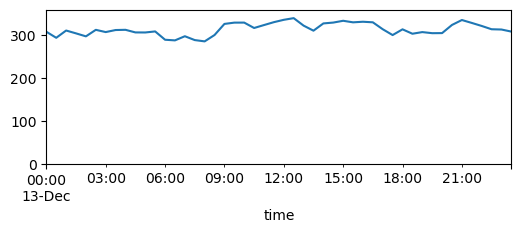

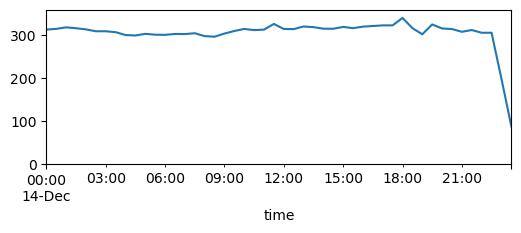

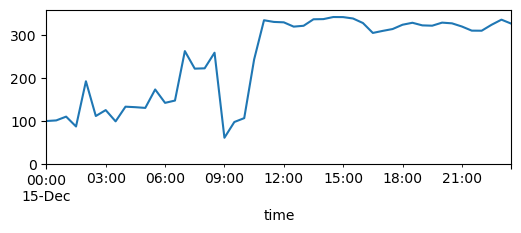

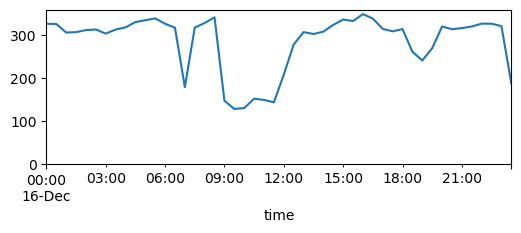

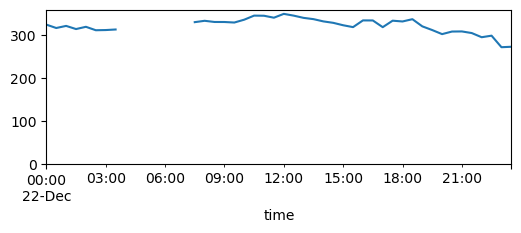

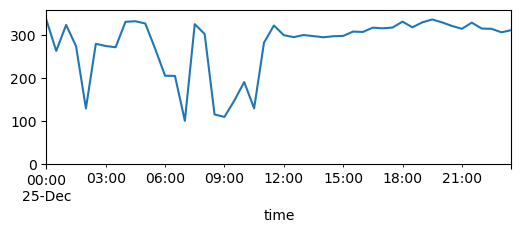

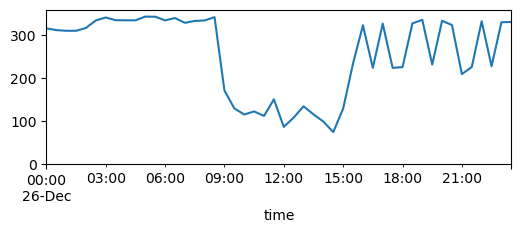

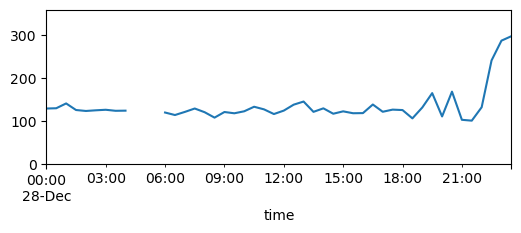

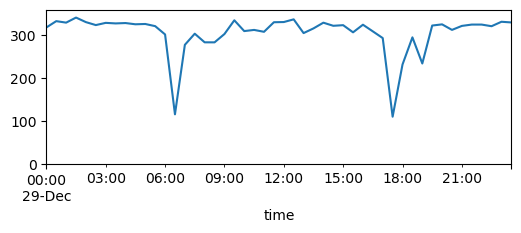

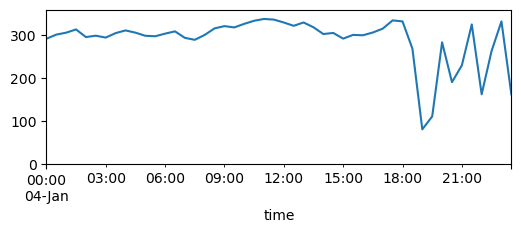

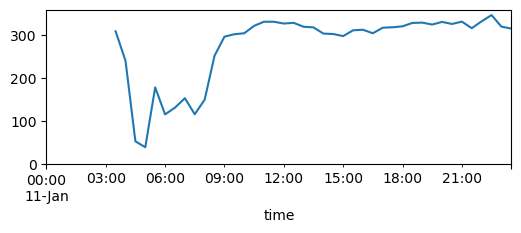

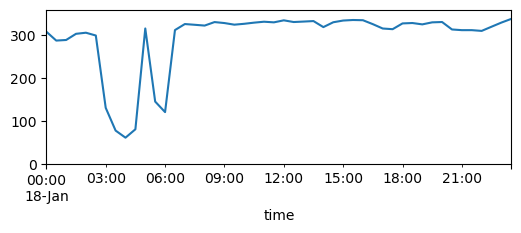

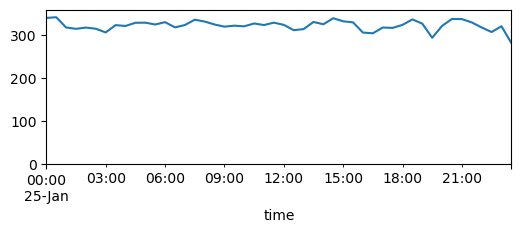

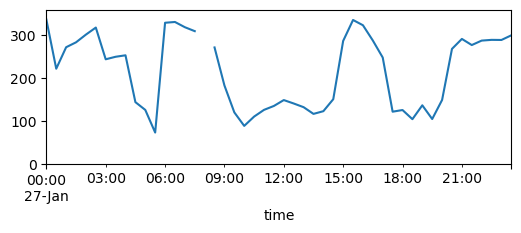

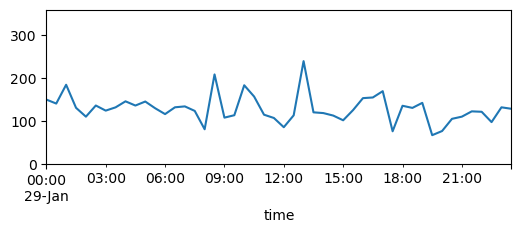

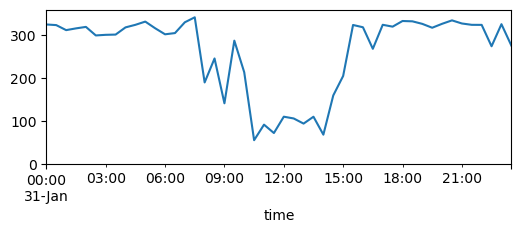

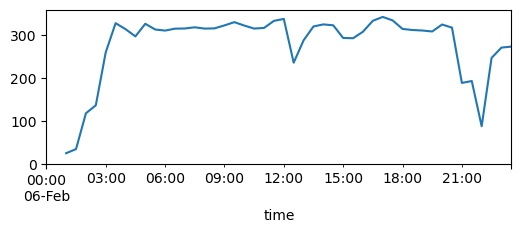

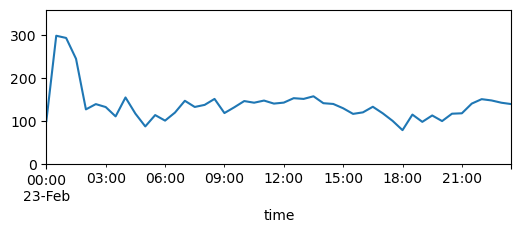

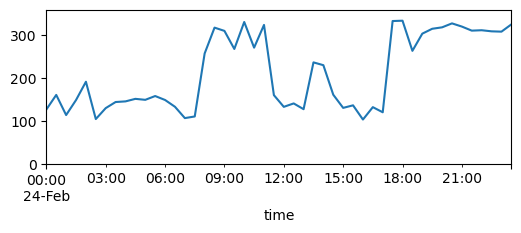

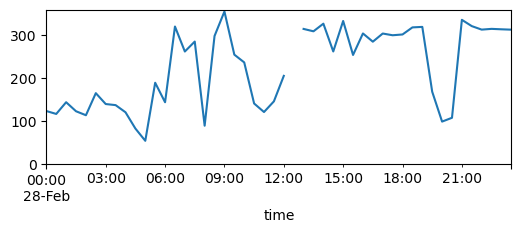

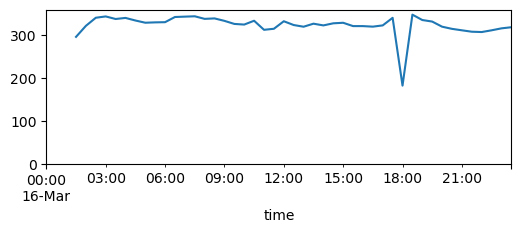

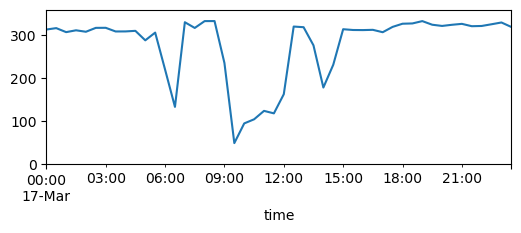

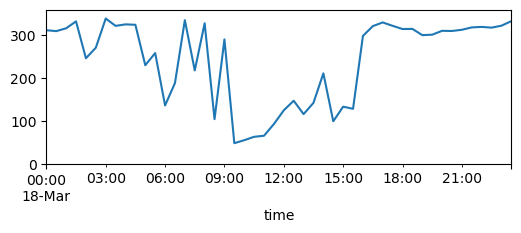

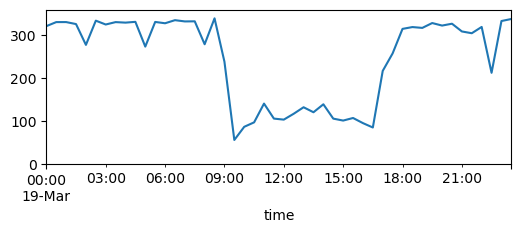

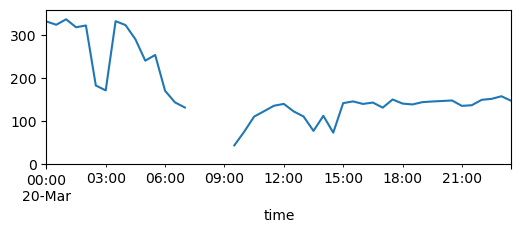

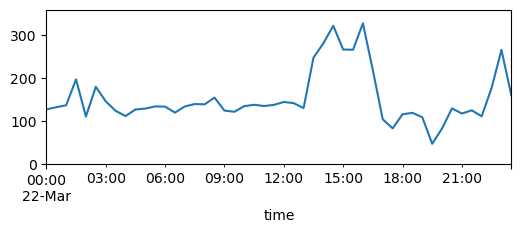

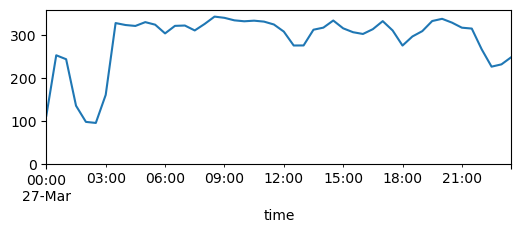

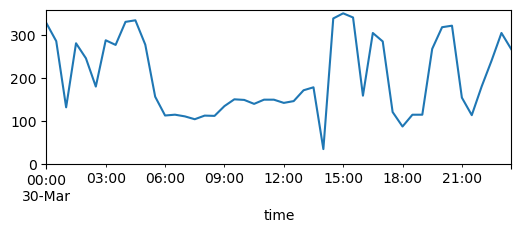

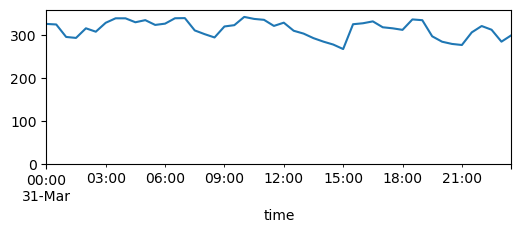

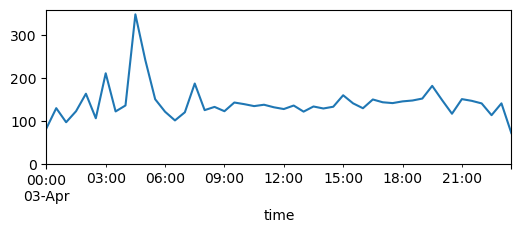

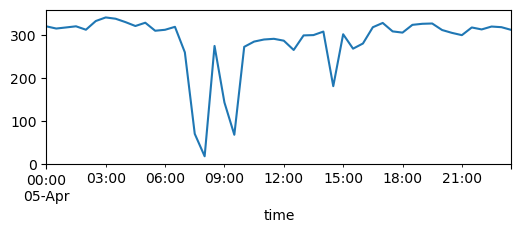

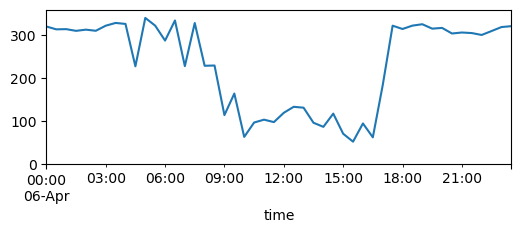

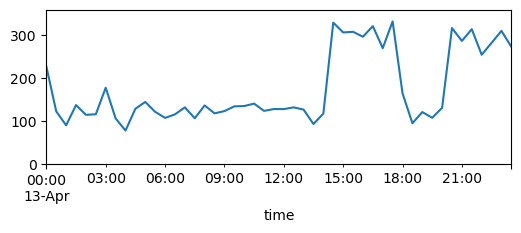

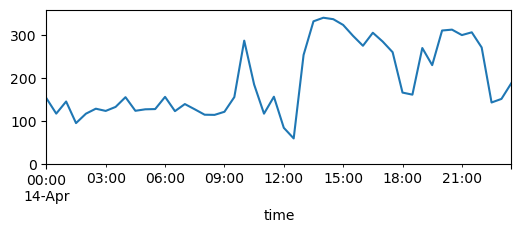

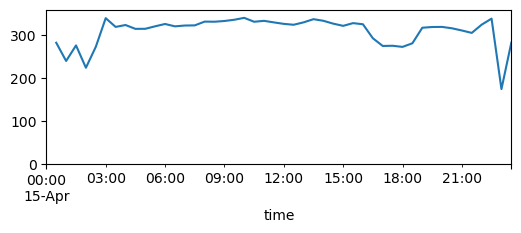

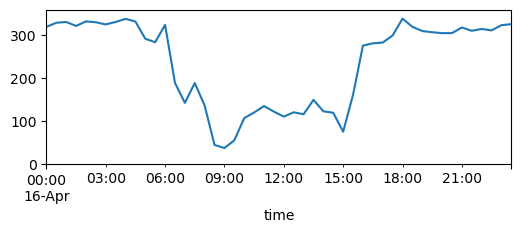

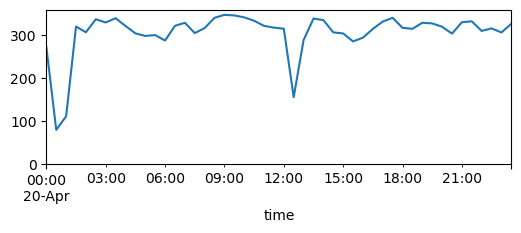

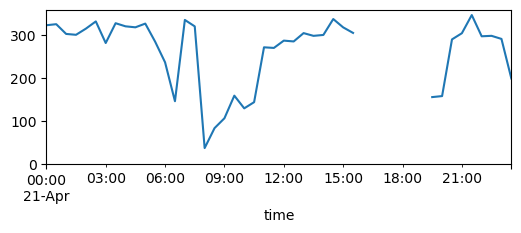

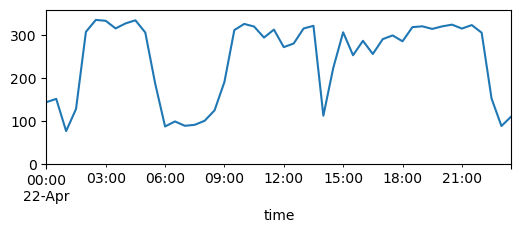

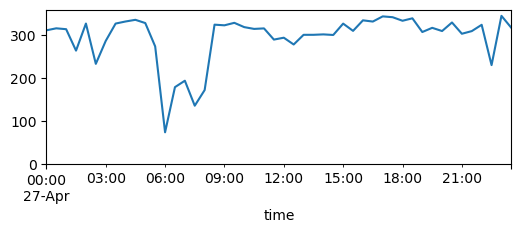

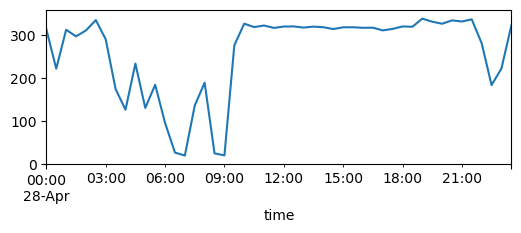

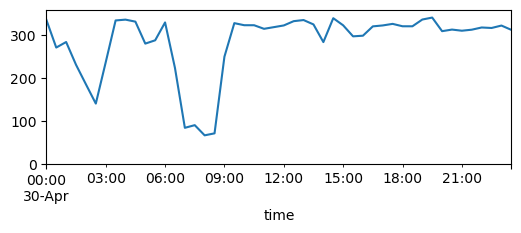

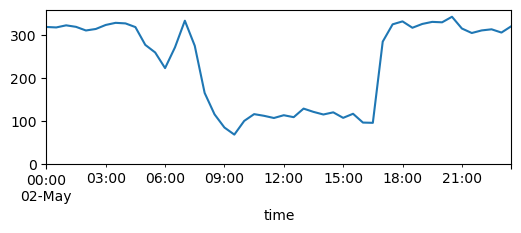

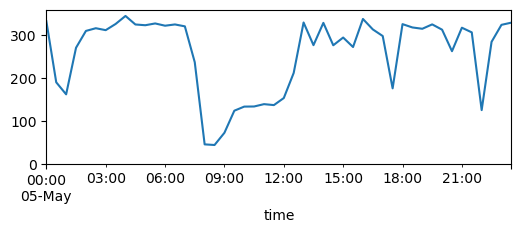

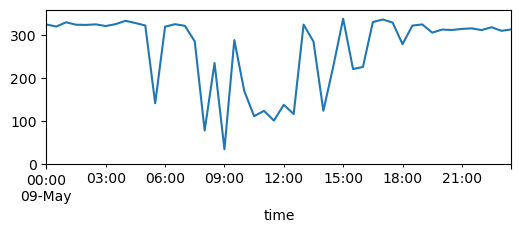

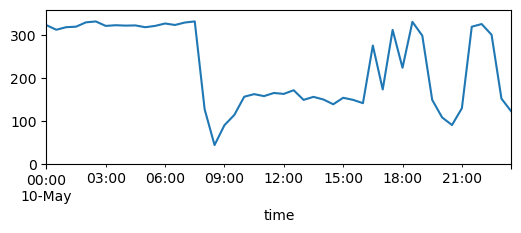

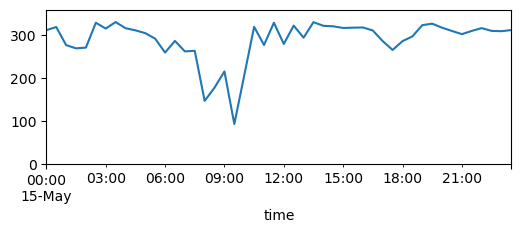

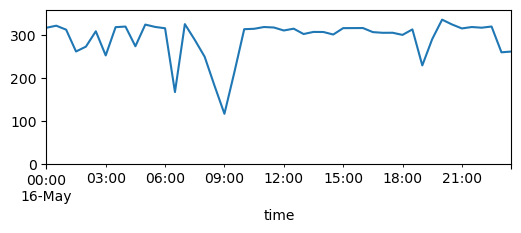

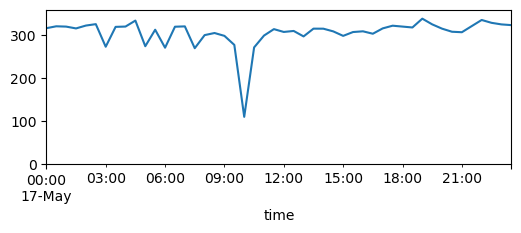

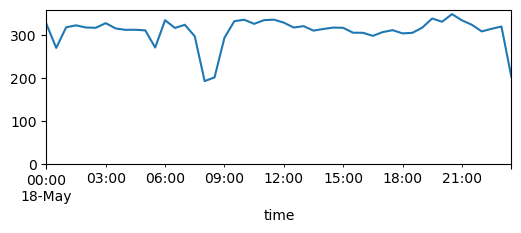

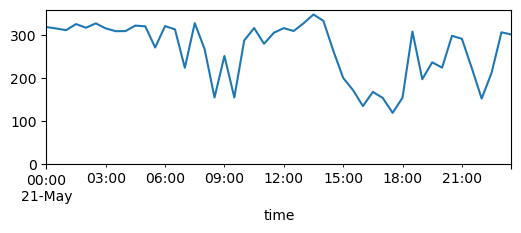

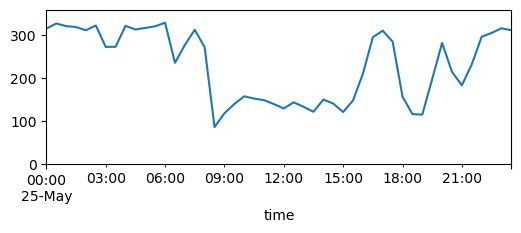

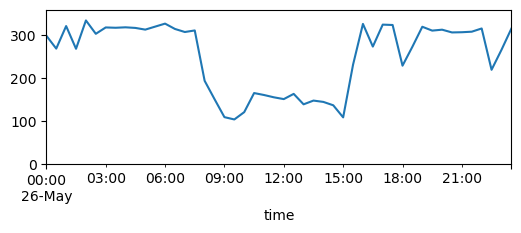

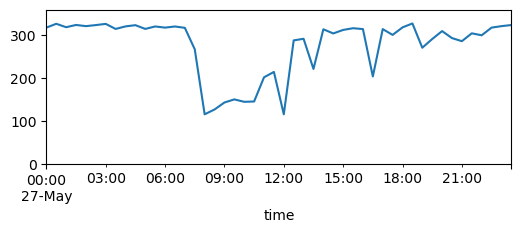

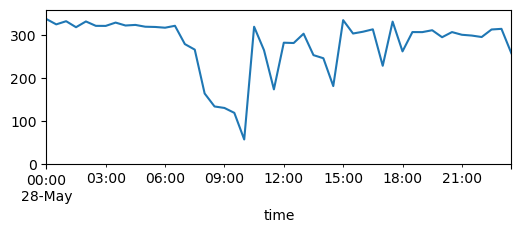

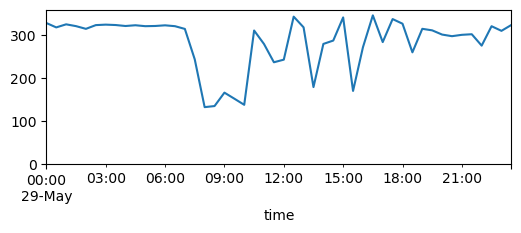

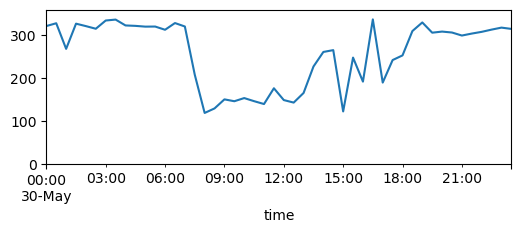

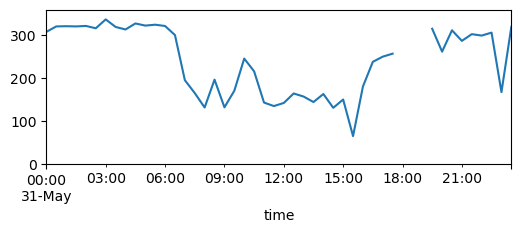

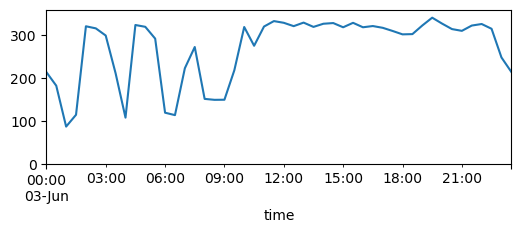

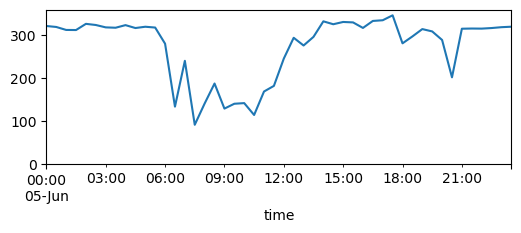

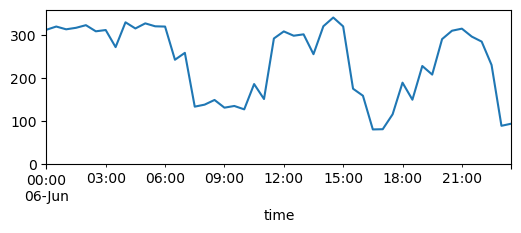

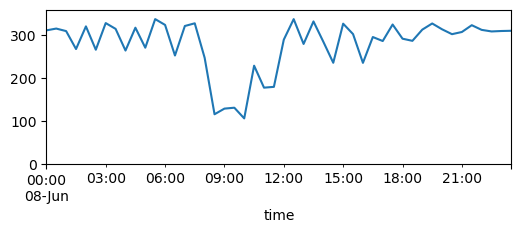

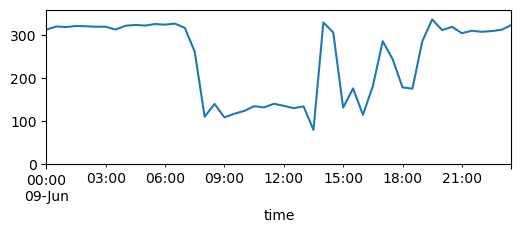

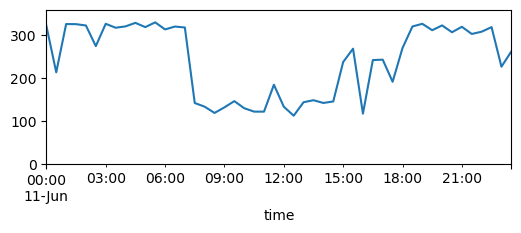

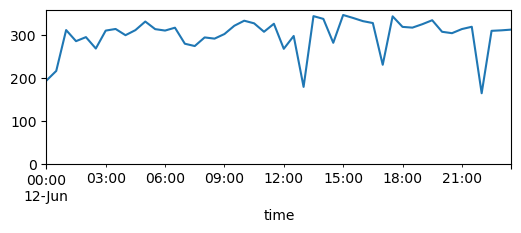

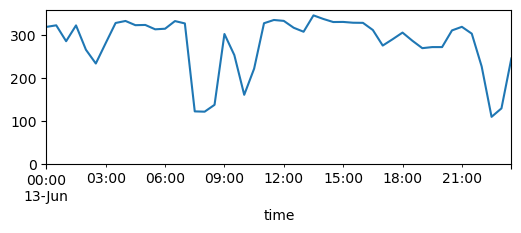

In [10]:
for date in dates_with_80percent_alongvalley:
    src = tidy_df[tidy_df.time.dt.date == date].query(f"variable == 'dir_3m_c'")
    plt.figure(figsize=(6,2))
    src.set_index('time').value.plot()
    plt.ylim(0,360)
    plt.show()

# Identify snowfall dates (from NCAR report)

In [7]:
snowfall_dates = """
Start Time,End Time
2022 Oct 23 04:00:00, 2022 Oct 23 07:00:00
2022 Oct 25 19:00:00, 2022 Oct 26 12:00:00
2022 Oct 26 21:00:00, 2022 Oct 27 05:00:00
2022 Nov 03 04:00:00, 2022 Nov 04 12:00:00
2022 Nov 05 02:00:00, 2022 Nov 05 17:00:00
2022 Nov 09 16:30:00, 2022 Nov 10 09:30:00
2022 Nov 18 05:00:00, 2022 Nov 18 08:00:00
2022 Nov 27 00:00:00, 2022 Nov 27 05:00:00
2022 Nov 28 18:00:00, 2022 Nov 29 14:00:00
2022 Dec 02 03:00:00, 2022 Dec 02 16:00:00
2022 Dec 03 17:00:00, 2022 Dec 04 17:00:00
2022 Dec 05 00:00:00, 2022 Dec 05 10:00:00
2022 Dec 06 00:00:00, 2022 Dec 07 14:00:00
2022 Dec 08 00:00:00, 2022 Dec 08 10:00:00
2022 Dec 20 18:00:00, 2022 Dec 22 07:00:00
2022 Dec 27 18:00:00, 2023 Jan 02 03:00:00
2023 Jan 02 10:00:00, 2023 Jan 04 06:00:00
2023 Jan 06 03:00:00, 2023 Jan 07 08:00:00
2023 Jan 09 22:00:00, 2023 Jan 12 00:00:00
2023 Jan 14 20:00:00, 2023 Jan 15 14:00:00
2023 Jan 16 00:00:00, 2023 Jan 18 10:00:00
2023 Jan 27 14:00:00, 2023 Jan 28 06:00:00
2023 Jan 29 00:00:00, 2023 Jan 31 17:00:00
2023 Feb 06 00:00:00, 2023 Feb 06 14:00:00
2023 Feb 13 12:00:00, 2023 Feb 15 07:00:00
2023 Feb 20 10:00:00, 2023 Feb 24 15:00:00
2023 Feb 28 00:00:00, 2023 Mar 02 06:00:00
2023 Mar 10 06:00:00, 2023 Mar 11 11:00:00
2023 Mar 12 00:00:00, 2023 Mar 16 00:00:00
2023 Mar 20 12:00:00, 2023 Mar 27 12:00:00
2023 Mar 30 15:00:00, 2023 Apr 01 07:00:00
2023 Apr 03 20:00:00, 2023 Apr 4 08:00:00
2023 Apr 14 10:00:00, 2023 Apr 15 14:00:00
2023 Apr 20 20:00:00, 2023 Apr 23 10:00:00
2023 Apr 24 22:00:00, 2023 Apr 26 00:00:00
2023 Apr 27 22:00:00, 2023 Apr 28 08:00:00
2023 May 10 22:00:00, 2023 May 12 08:00:00
"""
from io import StringIO
snowfall_df = pd.read_csv(StringIO(snowfall_dates))
snowfall_df['Start Time'] = pd.to_datetime(snowfall_df['Start Time'])
snowfall_df['End Time'] = pd.to_datetime(snowfall_df['End Time'])

timestamps_during_snowfall = np.concatenate(snowfall_df.apply(
    lambda row: pd.date_range(row['Start Time'], row['End Time'], freq='30Min').to_numpy(),
    axis=1
).values).ravel()

## Identify the relevant turbulent flux measurement variables

In [8]:
ec_lhflux_and_counts_variables = [
    ('w_h2o__2m_c', 'counts_2m_c_1'), 
    ('w_h2o__3m_c', 'counts_3m_c_1'), 
    ('w_h2o__5m_c', 'counts_5m_c_1'), 
    ('w_h2o__10m_c', 'counts_10m_c_1'), 
    ('w_h2o__15m_c', 'counts_15m_c_1'), 
    ('w_h2o__20m_c', 'counts_20m_c_1'), 


    # ('w_h2o__1m_d', 'counts_1m_d_1'), 
    ('w_h2o__3m_d', 'counts_3m_d_1'), 
    ('w_h2o__10m_d', 'counts_10m_d_1'), 
      
    # ('w_h2o__1m_ue', 'counts_1m_ue_1'), 
    ('w_h2o__3m_ue', 'counts_3m_ue_1'), 
    ('w_h2o__10m_ue', 'counts_10m_ue_1'), 


    # ('w_h2o__1m_uw',  'counts_1m_uw_1'), 
    ('w_h2o__3m_uw', 'counts_3m_uw_1'), 
    ('w_h2o__10m_uw', 'counts_10m_uw_1'), 
]
ec_lhflux_variables = list(zip(*ec_lhflux_and_counts_variables))[0]
counts_variables    = list(list(zip(*ec_lhflux_and_counts_variables))[1])

# Create wide df for analysis

In [9]:
bs_times = list(tidy_df[tidy_df.variable == 'SF_avg_ue'].query("value > 0").time.unique())
nobs_times = list(tidy_df[tidy_df.variable == 'SF_avg_ue'].query("value == 0").time.unique())

blowing_snow_vs_counts_src = tidy_df[tidy_df.variable.isin([
    'SF_avg_2m_ue', 
    'SF_avg_1m_ue', 
    'SF_avg_ue', 
    'Tsur'
    #############
    'counts_2m_c_1',    'ldiag_2m_c',    'irgadiag_2m_c',    'w_h2o__2m_c',  'spd_2m_c',     'RH_2m_c',      'Ri_2m_c',
    'counts_3m_c_1',    'ldiag_3m_c',    'irgadiag_3m_c',    'w_h2o__3m_c',  'spd_3m_c',     'RH_3m_c',      'Ri_3m_c',
    'counts_5m_c_1',    'ldiag_5m_c',    'irgadiag_5m_c',    'w_h2o__5m_c',  'spd_5m_c',     'RH_5m_c',      'Ri_5m_c',
    'counts_10m_c_1',   'ldiag_10m_c',   'irgadiag_10m_c',   'w_h2o__10m_c', 'spd_10m_c',    'RH_10m_c',     'Ri_10m_c',
    'counts_15m_c_1',   'ldiag_15m_c',   'irgadiag_15m_c',   'w_h2o__15m_c', 'spd_15m_c',    'RH_15m_c',     'Ri_15m_c',
    'counts_20m_c_1',   'ldiag_20m_c',   'irgadiag_20m_c',   'w_h2o__20m_c', 'spd_20m_c',    'RH_20m_c',     'Ri_20m_c',
    
    'temp_gradient_2m_c',
    'temp_gradient_3m_c',
    'temp_gradient_5m_c',
    'temp_gradient_10m_c',
    'temp_gradient_15m_c',
    'temp_gradient_20m_c',

    'Tsurfmixingratio_c',
    'mixingratio_1m_c', 'mixingratio_2m_c', 'mixingratio_3m_c', 'mixingratio_4m_c', 
    'mixingratio_5m_c', 'mixingratio_6m_c', 'mixingratio_7m_c', 'mixingratio_8m_c', 
    'mixingratio_9m_c', 'mixingratio_10m_c', 'mixingratio_11m_c', 'mixingratio_12m_c',
    'mixingratio_13m_c', 'mixingratio_14m_c', 'mixingratio_15m_c', 'mixingratio_16m_c', 
    'mixingratio_17m_c', 'mixingratio_18m_c', 'mixingratio_19m_c', 'mixingratio_20m_c',
])].pivot(
        index='time',
        columns='variable',
        values='value'
    ).reset_index()
blowing_snow_vs_counts_src['Dec 22'] = blowing_snow_vs_counts_src.time.dt.date == dt.date(2022, 12, 22)
blowing_snow_vs_counts_src['is snowing'] = blowing_snow_vs_counts_src.time.isin(timestamps_during_snowfall)
blowing_snow_vs_counts_src['is Dec 22 or is snowing'] = np.logical_or(blowing_snow_vs_counts_src['Dec 22'], blowing_snow_vs_counts_src['is snowing'])
blowing_snow_vs_counts_src['is blowing snow'] = blowing_snow_vs_counts_src["SF_avg_ue"] > 0
all_blowing_snow_data = blowing_snow_vs_counts_src.query("SF_avg_ue > 0")
allnot_blowing_snow_data = blowing_snow_vs_counts_src.query("SF_avg_ue == 0")

ValueError: Index contains duplicate entries, cannot reshape

# Examine when "bad" data occurs

## Using the Sonic flags (ldiag)

In [ ]:
bad_data_df_by_sonic = pd.DataFrame(np.array([
    np.array([
        "ldiag_2m_c",
        len(blowing_snow_vs_counts_src.query("ldiag_2m_c > 0.02")),   
        len(allnot_blowing_snow_data[~allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_2m_c > 0.02")),   
        len(allnot_blowing_snow_data[allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_2m_c > 0.02")),   
        len(all_blowing_snow_data[~all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_2m_c > 0.02")),
        len(all_blowing_snow_data[all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_2m_c > 0.02"))
    ]),
    np.array([
        "ldiag_3m_c",
        len(blowing_snow_vs_counts_src.query("ldiag_3m_c > 0.02")),   
        len(allnot_blowing_snow_data[~allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_3m_c > 0.02")),   
        len(allnot_blowing_snow_data[allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_3m_c > 0.02")),   
        len(all_blowing_snow_data[~all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_3m_c > 0.02")),
        len(all_blowing_snow_data[all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_3m_c > 0.02"))
    ]),
    np.array([
        "ldiag_5m_c",
        len(blowing_snow_vs_counts_src.query("ldiag_5m_c > 0.02")),   
        len(allnot_blowing_snow_data[~allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_5m_c > 0.02")),   
        len(allnot_blowing_snow_data[allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_5m_c > 0.02")),   
        len(all_blowing_snow_data[~all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_5m_c > 0.02")),
        len(all_blowing_snow_data[all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_5m_c > 0.02"))
    ]),
    np.array([
        "ldiag_10m_c",
        len(blowing_snow_vs_counts_src.query("ldiag_10m_c > 0.02")),  
        len(allnot_blowing_snow_data[~allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_10m_c > 0.02")),  
        len(allnot_blowing_snow_data[allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_10m_c > 0.02")),  
        len(all_blowing_snow_data[~all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_10m_c > 0.02")),
        len(all_blowing_snow_data[all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_10m_c > 0.02"))
    ]),
    np.array([
        "ldiag_15m_c",
        len(blowing_snow_vs_counts_src.query("ldiag_15m_c > 0.02")),  
        len(allnot_blowing_snow_data[~allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_15m_c > 0.02")),  
        len(allnot_blowing_snow_data[allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_15m_c > 0.02")),  
        len(all_blowing_snow_data[~all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_15m_c > 0.02")),
        len(all_blowing_snow_data[all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_15m_c > 0.02"))
    ]),
    np.array([
        "ldiag_20m_c",
        len(blowing_snow_vs_counts_src.query("ldiag_20m_c > 0.02")),  
        len(allnot_blowing_snow_data[~allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_20m_c > 0.02")),  
        len(allnot_blowing_snow_data[allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_20m_c > 0.02")),  
        len(all_blowing_snow_data[~all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_20m_c > 0.02")),
        len(all_blowing_snow_data[all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("ldiag_20m_c > 0.02"))
    ]),
]), columns=np.array([
        "variable",
        "total",
        "no_bs_no_snowfall",
        "no_bs_during_snowfall",
        "during_bs_no_snowfall",
        "during_bs_during_snowfall",
    ]),)
bad_data_df_by_sonic

,variable,total,no_bs_no_snowfall,no_bs_during_snowfall,during_bs_no_snowfall,during_bs_during_snowfall
0,ldiag_2m_c,180,3,24,37,114
1,ldiag_3m_c,68,8,16,8,34
2,ldiag_5m_c,59,12,2,9,34
3,ldiag_10m_c,112,2,0,19,89
4,ldiag_15m_c,244,0,0,61,181
5,ldiag_20m_c,233,7,1,66,157


## Using the Irgason flags (irgadiag)

In [ ]:
bad_data_df_by_irga = pd.DataFrame(np.array([
    np.array([
        "irgadiag_2m_c",
        len(blowing_snow_vs_counts_src.query("irgadiag_2m_c > 0")),   
        len(allnot_blowing_snow_data[~allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_2m_c > 0")),   
        len(allnot_blowing_snow_data[allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_2m_c > 0")),   
        len(all_blowing_snow_data[~all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_2m_c > 0")),
        len(all_blowing_snow_data[all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_2m_c > 0"))
    ]),
    np.array([
        "irgadiag_3m_c",
        len(blowing_snow_vs_counts_src.query("irgadiag_3m_c > 0")),   
        len(allnot_blowing_snow_data[~allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_3m_c > 0")),   
        len(allnot_blowing_snow_data[allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_3m_c > 0")),   
        len(all_blowing_snow_data[~all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_3m_c > 0")),
        len(all_blowing_snow_data[all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_3m_c > 0"))
    ]),
    np.array([
        "irgadiag_5m_c",
        len(blowing_snow_vs_counts_src.query("irgadiag_5m_c > 0")),   
        len(allnot_blowing_snow_data[~allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_5m_c > 0")),   
        len(allnot_blowing_snow_data[allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_5m_c > 0")),   
        len(all_blowing_snow_data[~all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_5m_c > 0")),
        len(all_blowing_snow_data[all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_5m_c > 0"))
    ]),
    np.array([
        "irgadiag_10m_c",
        len(blowing_snow_vs_counts_src.query("irgadiag_10m_c > 0")),  
        len(allnot_blowing_snow_data[~allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_10m_c > 0")),  
        len(allnot_blowing_snow_data[allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_10m_c > 0")),  
        len(all_blowing_snow_data[~all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_10m_c > 0")),
        len(all_blowing_snow_data[all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_10m_c > 0"))
    ]),
    np.array([
        "irgadiag_15m_c",
        len(blowing_snow_vs_counts_src.query("irgadiag_15m_c > 0")),  
        len(allnot_blowing_snow_data[~allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_15m_c > 0")),  
        len(allnot_blowing_snow_data[allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_15m_c > 0")),  
        len(all_blowing_snow_data[~all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_15m_c > 0")),
        len(all_blowing_snow_data[all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_15m_c > 0"))
    ]),
    np.array([
        "irgadiag_20m_c",
        len(blowing_snow_vs_counts_src.query("irgadiag_20m_c > 0")),  
        len(allnot_blowing_snow_data[~allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_20m_c > 0")),  
        len(allnot_blowing_snow_data[allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_20m_c > 0")),  
        len(all_blowing_snow_data[~all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_20m_c > 0")),
        len(all_blowing_snow_data[all_blowing_snow_data.time.isin(timestamps_during_snowfall)].query("irgadiag_20m_c > 0"))
    ]),
]), columns=np.array([
        "variable",
        "total",
        "no_bs_no_snowfall",
        "no_bs_during_snowfall",
        "during_bs_no_snowfall",
        "during_bs_during_snowfall",
    ]),)
bad_data_df_by_irga

,variable,total,no_bs_no_snowfall,no_bs_during_snowfall,during_bs_no_snowfall,during_bs_during_snowfall
0,irgadiag_2m_c,1528,212,794,85,435
1,irgadiag_3m_c,1470,218,772,77,403
2,irgadiag_5m_c,1039,130,563,48,298
3,irgadiag_10m_c,1237,174,644,68,351
4,irgadiag_15m_c,1063,556,337,35,135
5,irgadiag_20m_c,1235,341,546,48,300


In [ ]:
(alt.Chart(bad_data_df_by_sonic).transform_fold([
    'no_bs_no_snowfall', 'no_bs_during_snowfall', 'during_bs_no_snowfall', 'during_bs_during_snowfall'   
]).mark_bar().encode(
    alt.Y("variable").sort(['ldiag_2m_c', 'ldiag_3m_c', 'ldiag_5m_c', 'ldiag_10m_c', 'ldiag_15m_c', 'ldiag_20m_c']),
    alt.X("value:Q").title("n data points marked \"bad\""),
    alt.Color("key:N").title("Conditions")
).properties(title='Sonic anemometer flag') &
alt.Chart(bad_data_df_by_irga).transform_fold([
    'no_bs_no_snowfall', 'no_bs_during_snowfall', 'during_bs_no_snowfall', 'during_bs_during_snowfall'   
]).mark_bar().encode(
    alt.Y("variable").sort(['irgadiag_2m_c', 'irgadiag_3m_c', 'irgadiag_5m_c', 'irgadiag_10m_c', 'irgadiag_15m_c', 'irgadiag_20m_c']),
    alt.X("value:Q").title("n data points marked \"bad\""),
    alt.Color("key:N").title("Conditions")
).properties(title='Irgason flag')).display(renderer='svg')

alt.VConcatChart(...)

## Plot sonic and irga flags during and not during blowing snow, as functions of 1. blowing snow flux and 2. RH

In [ ]:
def chart(src, var1, var2):
    rule = alt.Chart().transform_calculate(rule='0.1').mark_rule(strokeDash=[4,2]).encode(y='rule:Q')
    return rule + alt.Chart(src).mark_circle(size=10).encode(
        alt.X(f"{var1}:Q").scale(type='log'),
        alt.Y(f"{var2}:Q").scale(type='symlog', constant=0.005, domain=[0,1]).axis(format="1e").title(var2),
        alt.Color("Dec 22:N").title("On Dec. 22"),
        tooltip='time:T'
    ).properties(width = 150, height= 150)
def symlogchart(src, var1, var2):
    rule = alt.Chart().transform_calculate(rule='0.1').mark_rule(strokeDash=[4,2]).encode(y='rule:Q')
    return rule + alt.Chart(src).mark_circle(size=10).encode(
        alt.X(f"{var1}:Q").scale(type='log'),
        alt.Y(f"{var2}:Q").scale(type='symlog').axis(values=[0,10,100,1000,10000,100000,1000000], format="1e").title(var2),
        alt.Color("Dec 22:N").title("On Dec. 22"),
        tooltip='time:T'
    ).properties(width = 150, height= 150)

(
    (chart(all_blowing_snow_data, 'SF_avg_ue', 'ldiag_3m_c') | ( chart(all_blowing_snow_data, 'SF_avg_ue', 'ldiag_20m_c'))).resolve_scale(y='shared')
    & 
    (symlogchart(all_blowing_snow_data, 'SF_avg_ue', 'irgadiag_3m_c', ) |  symlogchart(all_blowing_snow_data, 'SF_avg_ue', 'irgadiag_20m_c', )).resolve_scale(y='shared')
).properties(title='During blowing snow').resolve_scale(x='shared').display(renderer='svg')

alt.VConcatChart(...)

In [ ]:
def chart(src, var1, var2):
    rule = alt.Chart().transform_calculate(rule='0.1').mark_rule(strokeDash=[4,2]).encode(y='rule:Q')
    return rule + alt.Chart(src).mark_circle(size=10).encode(
        alt.X(f"{var1}:Q"),
        alt.Y(f"{var2}:Q").axis(format="1e").title(var2),
        alt.Color("is blowing snow:N").title("is blowing snow"),
        tooltip='time:T'
    ).properties(width = 150, height= 150)
def symlogchart(src, var1, var2):
    rule = alt.Chart().transform_calculate(rule='0.1').mark_rule(strokeDash=[4,2]).encode(y='rule:Q')
    return rule + alt.Chart(src).mark_circle(size=10).encode(
        alt.X(f"{var1}:Q"),
        alt.Y(f"{var2}:Q").scale(type='symlog').axis(values=[0,10,100,1000,10000,100000,1000000], format="1e").title(var2),
        alt.Color("is blowing snow:N").title("is blowing snow"),
        tooltip='time:T'
    ).properties(width = 150, height= 150)

src_nosnowfall = blowing_snow_vs_counts_src[~blowing_snow_vs_counts_src['is snowing']]
src_duringsnowfall = blowing_snow_vs_counts_src[blowing_snow_vs_counts_src['is snowing']]
(
    (
        (chart(src_nosnowfall, 'RH_3m_c', 'ldiag_3m_c') | chart(src_nosnowfall, 'RH_20m_c', 'ldiag_20m_c') ).resolve_scale(y='shared')
        &
        (symlogchart(src_nosnowfall, 'RH_3m_c', 'irgadiag_3m_c', ) | symlogchart(src_nosnowfall, 'RH_20m_c', 'irgadiag_20m_c', ) ).resolve_scale(y='shared')
    ).properties(title='No snowfall')
    |
    (
        (chart(src_duringsnowfall, 'RH_3m_c', 'ldiag_3m_c') | chart(src_duringsnowfall, 'RH_20m_c', 'ldiag_20m_c') ).resolve_scale(y='shared')
        &
        (symlogchart(src_duringsnowfall, 'RH_3m_c', 'irgadiag_3m_c', ) | symlogchart(src_duringsnowfall, 'RH_20m_c', 'irgadiag_20m_c', ) ).resolve_scale(y='shared')
    ).properties(title='During snowfall')
).resolve_scale(x='shared').configure_axis(grid=False).display(renderer='svg')

alt.HConcatChart(...)

## Examine the cloud of bad data at 20m during low humidity

In [ ]:
src_20 = src_nosnowfall.query("RH_20m_c < 60").query("irgadiag_20m_c > 10000")
src_15 = src_nosnowfall.query("RH_20m_c < 60").query("irgadiag_15m_c > 10000")
src_10 = src_nosnowfall.query("RH_20m_c < 60").query("irgadiag_10m_c > 10000")

In [ ]:
(alt.Chart(src_20).mark_tick().encode(alt.X("time:T"), tooltip='time:T').properties(width = 800, height = 50) &\
alt.Chart(src_15).mark_tick().encode(alt.X("time:T"), tooltip='time:T').properties(width = 800, height = 50) &\
alt.Chart(src_10).mark_tick().encode(alt.X("time:T"), tooltip='time:T').properties(width = 800, height = 50)
).resolve_scale(x='shared').interactive()

alt.VConcatChart(...)

In [ ]:
alt.Chart()

In [ ]:
    tidy_df[
        (tidy_df.time >= "20230410") & (tidy_df.time < "20230411")
    ][
        tidy_df.measurement.isin(['temperature', 'surface temperature'])
    ][
        tidy_df.variable != 'Tsurfplanck_c'
    ].query("tower == 'c'").dropna().head(20)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_66557/3381404814.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df[
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_66557/3381404814.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df[


,time,variable,value,height,tower,measurement
4781782,2023-04-10,T_19m_c,-2.357595,19.0,c,temperature
4781824,2023-04-10,T_4m_c,-4.640913,4.0,c,temperature
4781836,2023-04-10,T_13m_c,-2.993063,13.0,c,temperature
4781880,2023-04-10,T_10m_c,-3.336161,10.0,c,temperature
4781943,2023-04-10,T_18m_c,-2.464264,18.0,c,temperature
4781975,2023-04-10,T_9m_c,-3.519968,9.0,c,temperature
4782032,2023-04-10,T_20m_c,-2.229715,20.0,c,temperature
4782063,2023-04-10,T_5m_c,-4.323652,5.0,c,temperature
4782124,2023-04-10,T_14m_c,-2.804143,14.0,c,temperature
4782165,2023-04-10,T_8m_c,-3.703139,8.0,c,temperature


In [ ]:
alt.Chart(
    tidy_df[
        (tidy_df.time >= "20230410") & (tidy_df.time < "20230411")
    ][
        tidy_df.measurement.isin(['temperature', 'surface temperature'])
    ][
        tidy_df.variable != 'Tsurfplanck_c'
    ].query("tower == 'c'")
).mark_line().encode(
    alt.X("value:Q").sort('y'),
    alt.Y("height:Q"),
    alt.Facet('time:T', columns=12).header(format='%H%M')
).properties(width=100,height=100)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_66557/2801859333.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df[
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_66557/2801859333.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df[


alt.Chart(...)

In [ ]:
blowing_snow_vs_counts_src['irga_bad_3m_c'] = blowing_snow_vs_counts_src['irgadiag_3m_c'] > 0
blowing_snow_vs_counts_src['irga_bad_20m_c'] = blowing_snow_vs_counts_src['irgadiag_20m_c'] > 0

In [ ]:
(
    alt.Chart(blowing_snow_vs_counts_src).mark_boxplot(outliers=True).encode(
        alt.Y("irga_bad_3m_c:N").title("Bad Irgason"),
        alt.X("temp_gradient_3m_c:Q").title("dθᵥ /dz at 3 meters")
    ).properties(title="3m") & alt.Chart(blowing_snow_vs_counts_src).mark_boxplot(outliers=True).encode(
        alt.Y("irga_bad_20m_c:N").title("Bad Irgason"),
        alt.X("temp_gradient_20m_c:Q").title("dθᵥ /dz at 3 meters")
    ).properties(title="20m")
).display(renderer='svg')

alt.VConcatChart(...)

In [ ]:
blowing_snow_vs_counts_src['mixingratio_bulkgrad_3m_c'] = (
    blowing_snow_vs_counts_src['mixingratio_3m_c'] - blowing_snow_vs_counts_src['Tsurfmixingratio_c']
) / 3

blowing_snow_vs_counts_src['mixingratio_bulkgrad_20m_c'] = (
    blowing_snow_vs_counts_src['mixingratio_20m_c'] - blowing_snow_vs_counts_src['Tsurfmixingratio_c']
) / 20

In [ ]:
rule = alt.Chart().transform_calculate(rule='0').mark_rule(strokeWidth=2).encode(x='rule:Q')
(rule + alt.Chart(blowing_snow_vs_counts_src.query("w_h2o__3m_c > 0")).mark_boxplot(outliers=True).encode(
    alt.Y("irga_bad_3m_c:N").title(["Irgason", "data is bad"]),
    alt.X("mixingratio_bulkgrad_3m_c:Q").title(
        "Bulk gradient of mixing ratio gradient (dr/dz), 0-3 meters"
    ).axis(values = [-0.0006, 0.0002])
)).display(renderer='svg')

alt.LayerChart(...)

# Examine distributions of water vapor flux during these different bad data periods

In [ ]:
all_data_df = blowing_snow_vs_counts_src.copy()
nobs_nosnowfall_df =    allnot_blowing_snow_data[~allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)]
nobs_snowfall_df =      allnot_blowing_snow_data[allnot_blowing_snow_data.time.isin(timestamps_during_snowfall)]
bs_nosnowfall_df =      all_blowing_snow_data[~all_blowing_snow_data.time.isin(timestamps_during_snowfall)]
bs_snowfall_df =        all_blowing_snow_data[all_blowing_snow_data.time.isin(timestamps_during_snowfall)]

all_data_df['qc'] =           (all_data_df["counts_3m_c_1"] < 32400).apply(lambda is_bad: "good" if not is_bad else "bad")
nobs_nosnowfall_df['qc'] = (nobs_nosnowfall_df["counts_3m_c_1"] < 32400).apply(lambda is_bad: "good" if not is_bad else "bad")
nobs_snowfall_df['qc'] =   (nobs_snowfall_df["counts_3m_c_1"] < 32400).apply(lambda is_bad: "good" if not is_bad else "bad")
bs_nosnowfall_df['qc'] =   (bs_nosnowfall_df["counts_3m_c_1"] < 32400).apply(lambda is_bad: "good" if not is_bad else "bad")
bs_snowfall_df['qc'] =     (bs_snowfall_df["counts_3m_c_1"] < 32400).apply(lambda is_bad: "good" if not is_bad else "bad")

In [ ]:
(
    (
        alt.Chart(all_data_df).mark_bar().encode(
            alt.X("w_h2o__3m_c:Q").bin(maxbins=25),
            alt.Y("count():Q").stack(None),
            alt.Color("qc:N")
        ).properties(
            height = 150, 
            title=[
                f"All data",
                f"(n = {len(all_data_df)}/{len(all_data_df)}), " +
                f"{round(100*len(all_data_df.query("qc =='bad'"))/len(all_data_df))}% bad, " +
                f"{round(100*len(all_data_df.query("qc =='good'"))/len(all_data_df))}% good)"
            ]
        )) 
        &\
    (
        
        ####  NOT DURING BS ####
        ################################################
        alt.Chart(nobs_nosnowfall_df).mark_bar().encode(
            alt.X("w_h2o__3m_c:Q").bin(maxbins=25),
            alt.Y("count():Q").stack(None),
            alt.Color("qc:N")
        ).properties(
            height = 150, 
            title=[
                f"No BS, no snowfall",
                f"(n = {len(nobs_nosnowfall_df)}/{len(all_data_df)}), " +
                f"{round(100*len(nobs_nosnowfall_df.query("qc =='bad'"))/len(nobs_nosnowfall_df))}% bad, " +
                f"{round(100*len(nobs_nosnowfall_df.query("qc =='good'"))/len(nobs_nosnowfall_df))}% good)"
            ]
        ) |\
        alt.Chart(nobs_snowfall_df).mark_bar().encode(
            alt.X("w_h2o__3m_c:Q").bin(maxbins=25),
            alt.Y("count():Q").stack(None),
            alt.Color("qc:N")
        ).properties(
            height = 150, 
            title=[
                f"No BS, during snowfall",
                f"(n = {len(nobs_snowfall_df)}/{len(all_data_df)}), " +
                f"{round(100*len(nobs_snowfall_df.query("qc =='bad'"))/len(nobs_snowfall_df))}% bad, " +
                f"{round(100*len(nobs_snowfall_df.query("qc =='good'"))/len(nobs_snowfall_df))}% good)"
            ]
        )
    ).resolve_scale(x='shared', y='shared') &
    
    #### DURING BS ####
    ################################################
    (
        alt.Chart(bs_nosnowfall_df).mark_bar().encode(
            alt.X("w_h2o__3m_c:Q").bin(maxbins=25),
            alt.Y("count():Q").stack(None),
            alt.Color("qc:N")
        ).properties(
            height = 150, 
            title=[
                f"During BS, no snowfall",
                f"(n = {len(bs_nosnowfall_df)}/{len(all_data_df)}), " +
                f"{round(100*len(bs_nosnowfall_df.query("qc =='bad'"))/len(bs_nosnowfall_df))}% bad, " +
                f"{round(100*len(bs_nosnowfall_df.query("qc =='good'"))/len(bs_nosnowfall_df))}% good)"
            ]
        ) |\
        alt.Chart(bs_snowfall_df).mark_bar().encode(
            alt.X("w_h2o__3m_c:Q").bin(maxbins=25),
            alt.Y("count():Q").stack(None),
            alt.Color("qc:N")
        ).properties(
            height = 150, 
            title=[
                f"During BS, during snowfall",
                f"(n = {len(bs_snowfall_df)}/{len(all_data_df)}), " +
                f"{round(100*len(bs_snowfall_df.query("qc =='bad'"))/len(bs_snowfall_df))}% bad, " +
                f"{round(100*len(bs_snowfall_df.query("qc =='good'"))/len(bs_snowfall_df))}% good)"
            ]
        )
    ).resolve_scale(x='shared', y='shared')


).resolve_scale(x='shared', y='shared').properties(title=[
    "Distributions of latent heat flux measurements during different weather conditions",
    "Latent heat fluxes are measured at 3m. \"bad\" data has more than 10% of ",
    "instantaneous (20Hz) measurements flagged by instruments."
]).display(renderer='svg')

In [ ]:
(
    (
        alt.Chart(all_data_df).mark_bar().encode(
            alt.X("w_h2o__3m_c:Q").bin(maxbins=25),
            alt.Y("count():Q").stack(None),
            alt.Color("qc:N")
        ).properties(
            height = 150, 
            title=[
                f"All data",
                f"(n = {len(all_data_df)}/{len(all_data_df)}), " +
                f"{round(100*len(all_data_df.query("qc =='bad'"))/len(all_data_df))}% bad, " +
                f"{round(100*len(all_data_df.query("qc =='good'"))/len(all_data_df))}% good)"
            ]
        )) 
        &\
    (
        
        ####  NOT DURING BS ####
        ################################################
        alt.Chart(nobs_nosnowfall_df).mark_bar().encode(
            alt.X("w_h2o__3m_c:Q").bin(maxbins=25),
            alt.Y("count():Q").stack(None),
            alt.Color("qc:N")
        ).properties(
            height = 150, 
            title=[
                f"No BS, no snowfall",
                f"(n = {len(nobs_nosnowfall_df)}/{len(all_data_df)}), " +
                f"{round(100*len(nobs_nosnowfall_df.query("qc =='bad'"))/len(nobs_nosnowfall_df))}% bad, " +
                f"{round(100*len(nobs_nosnowfall_df.query("qc =='good'"))/len(nobs_nosnowfall_df))}% good)"
            ]
        ) |\
        alt.Chart(nobs_snowfall_df).mark_bar().encode(
            alt.X("w_h2o__3m_c:Q").bin(maxbins=25),
            alt.Y("count():Q").stack(None),
            alt.Color("qc:N")
        ).properties(
            height = 150, 
            title=[
                f"No BS, during snowfall",
                f"(n = {len(nobs_snowfall_df)}/{len(all_data_df)}), " +
                f"{round(100*len(nobs_snowfall_df.query("qc =='bad'"))/len(nobs_snowfall_df))}% bad, " +
                f"{round(100*len(nobs_snowfall_df.query("qc =='good'"))/len(nobs_snowfall_df))}% good)"
            ]
        )
    ).resolve_scale(x='shared', y='shared') &
    
    #### DURING BS ####
    ################################################
    (
        alt.Chart(bs_nosnowfall_df).mark_bar().encode(
            alt.X("w_h2o__3m_c:Q").bin(maxbins=25),
            alt.Y("count():Q").stack(None),
            alt.Color("qc:N")
        ).properties(
            height = 150, 
            title=[
                f"During BS, no snowfall",
                f"(n = {len(bs_nosnowfall_df)}/{len(all_data_df)}), " +
                f"{round(100*len(bs_nosnowfall_df.query("qc =='bad'"))/len(bs_nosnowfall_df))}% bad, " +
                f"{round(100*len(bs_nosnowfall_df.query("qc =='good'"))/len(bs_nosnowfall_df))}% good)"
            ]
        ) |\
        alt.Chart(bs_snowfall_df).mark_bar().encode(
            alt.X("w_h2o__3m_c:Q").bin(maxbins=25),
            alt.Y("count():Q").stack(None),
            alt.Color("qc:N")
        ).properties(
            height = 150, 
            title=[
                f"During BS, during snowfall",
                f"(n = {len(bs_snowfall_df)}/{len(all_data_df)}), " +
                f"{round(100*len(bs_snowfall_df.query("qc =='bad'"))/len(bs_snowfall_df))}% bad, " +
                f"{round(100*len(bs_snowfall_df.query("qc =='good'"))/len(bs_snowfall_df))}% good)"
            ]
        )
    ).resolve_scale(x='shared', y='shared')


).resolve_scale(x='shared', y='shared').properties(title=[
    "Distributions of latent heat flux measurements during different weather conditions",
    "Latent heat fluxes are measured at 3m. \"bad\" data has more than 10% of ",
    "instantaneous (20Hz) measurements flagged by instruments."
]).display(renderer='svg')

# Implement mean diurnal cycle gap filling for latent heat fluxes

In [ ]:
print("variable,n_nans_before,total_sub_before,n_nans_after,total_sub_after")
for lhflux_variable in [
    'w_h2o__2m_c',
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_h2o__10m_c',
    'w_h2o__15m_c',
    'w_h2o__20m_c',
    'w_h2o__3m_ue',
    'w_h2o__10m_ue',
    'w_h2o__3m_uw',
    'w_h2o__10m_uw',
    'w_h2o__3m_d',
    'w_h2o__10m_d',
]:
    subset = tidy_df[tidy_df.variable == lhflux_variable].set_index('time')
    n_nans_before = subset['value'].isna().sum()
    total_sub_before = (subset['value']*30*60/1000).sum()    
    for i,row in subset.iterrows():
        if np.isnan(row['value']):
            start_window = i - dt.timedelta(days=3, hours=12)
            end_window = i + dt.timedelta(days=3, hours=12)
            src = subset.loc[start_window: end_window].reset_index()
            means = pd.DataFrame(
                src.groupby([src.time.dt.hour, src.time.dt.minute])['value'].mean()
            )
            subset.loc[i, 'value'] = means.loc[i.hour, i.minute].value
    new_values = subset['value'].values
    measurement = subset['measurement'].values[0]
    height = subset['height'].values[0]
    tower = subset['tower'].values[0]
    # Remove old values for variable
    tidy_df = tidy_df[
        tidy_df.variable !=  lhflux_variable
    ]
    # Add new values for variable
    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,
        new_values,
        lhflux_variable,
        measurement,
        height,
        tower
    )
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time')['value'].isna().sum()
    n_nans_after = subset['value'].isna().sum()
    total_sub_after = (subset['value']*30*60/1000).sum()
    print(lhflux_variable, n_nans_before, round(total_sub_before,1), n_nans_after, round(total_sub_after,1))

# Save cleaned data

In [ ]:
tidy_df.to_parquet(output_fn)

In [ ]:
ls -lah | grep parquet

# Explore the data points we left out, based on the thresholds (for filtering data) that we determined earlier
# These are the datapoints we don't trust and are excluding - we should get an idea of what's happening during these limited times
* Measurements during times where SF_avg_XX_ue measurements are > 10^0, and have “good data” counts less than 0.9*6000 
* If too much data, only remove isolated incidents (I.e. less than 2 of those data points in a row)

In [ ]:
alt.Chart(
    tidy_df[
        tidy_df.variable == 'cumulative_sub_measured_10m_d'
    ].set_index('time').loc[
        "2023-04-24":"2023-04-26"
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q")
)


In [ ]:
bad_data = tidy_df[
    tidy_df.variable.isin(['SF_avg_2m_ue', 'SF_avg_1m_ue'])
].query("value > 1")

In [ ]:
bad_data = bad_data.sort_values('time')
bad_data['month'] = bad_data.time.dt.month

In [ ]:
alt.Chart(
    bad_data
).mark_tick().encode(
    alt.X("time:T").title(None),
    alt.Row("month:O").sort([12,1,2,3,4])
).resolve_scale(x='independent', y='shared').properties(width=400)

Select a few case studies based on the plot of bad data occurences above

In [ ]:
case_study_ls = [
    ("20221213", "20221215"),
    ("20221221", "20221223"),
    ("2023-01-10 12:00:00" , "2023-01-10 14:00:00"),
    ("20230205", "20230207"),
    ("20230308", "20230310"),
    ("20230330", "20230401"),
    ("20230403", "20230404"),
    ("20230424 2300", "20230425 0200"),
    

]

In [ ]:
tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet')

In [ ]:
src = tidy_df[
        tidy_df.variable.isin(list(sum(ec_lhflux_and_counts_variables, ())) + [
            'spd_3m_c', 'spd_5m_c', 'spd_10m_c', 'spd_15m_c', 'spd_20m_c',
            'spd_3m_d', 'spd_10m_d',
            'spd_3m_ue', 'spd_10m_ue',
            'spd_3m_uw', 'spd_10m_uw',
        ])
    ].set_index('time').sort_index()
src['tower and height'] = src.apply(lambda row : row['tower'] + ' ' + str(row['height']), axis=1)

In [ ]:
data_dropped_case_study_src = src[
        case_study_ls[1][0]: case_study_ls[1][1]
    ].reset_index().query("tower == 'c'").query("height == 3")

base_chart = alt.Chart().mark_line().properties(
    height = 100,
    width = 200
)
data_dropped_case_study_plot = (
    alt.layer(
        base_chart, data=data_dropped_case_study_src.query(
            "measurement == 'eddy covariance h2o high rate count'"
        )
    ).encode(
        alt.X("time:T"),
        alt.Y("value:Q").title(["Count unflagged 20hz w'q'", "measurements, 3m Tower C"]),
    ) & 
    alt.layer(
        base_chart, data=data_dropped_case_study_src.query(
            "measurement == 'w_h2o_'"
        )
    ).encode(
        alt.X("time:T"),
        alt.Y("value:Q").title(["w'q'", "3m Tower C"]),
    ) & 
    alt.layer(
        base_chart, data=data_dropped_case_study_src.query(
            "measurement == 'wind speed'"
        )
    ).encode(
        alt.X("time:T"),
        alt.Y("value:Q").title(["Wind speed", "3m Tower C"]),
    )
).resolve_scale(x='shared')

In [ ]:
no_data_dropped_case_study_src = src[
        case_study_ls[0][0]: case_study_ls[0][1]
    ].reset_index().query("tower == 'ue'").query("height == 10")

base_chart = alt.Chart().mark_line().properties(
    height = 100,
    width = 200
)
no_data_dropped_case_study_plot = (
    alt.layer(
        base_chart, data=no_data_dropped_case_study_src.query(
            "measurement == 'eddy covariance h2o high rate count'"
        )
    ).encode(
        alt.X("time:T"),
        alt.Y("value:Q").title(["Count unflagged 20hz w'q'", "measurements, 10m Tower UE"]),
    ) & 
    alt.layer(
        base_chart, data=no_data_dropped_case_study_src.query(
            "measurement == 'w_h2o_'"
        )
    ).encode(
        alt.X("time:T"),
        alt.Y("value:Q").title(["w'q'", "10m Tower UE"]),
    ) & 
    alt.layer(
        base_chart, data=no_data_dropped_case_study_src.query(
            "measurement == 'wind speed'"
        )
    ).encode(
        alt.X("time:T"),
        alt.Y("value:Q").title(["Wind speed", "10m Tower UE"]),
    )
).resolve_scale(x='shared')

In [ ]:
data_dropped_casestudies_chart = (no_data_dropped_case_study_plot | data_dropped_case_study_plot)
data_dropped_casestudies_chart.save("data_dropped_casestudies_chart.png", ppi=200)
data_dropped_casestudies_chart

In [ ]:
alt.Chart(
    src[
        case_study_ls[0][0]: case_study_ls[0][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

In [ ]:
alt.Chart(
    src[
        case_study_ls[1][0]: case_study_ls[1][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

In [ ]:
alt.Chart(
    src[
        case_study_ls[2][0]: case_study_ls[2][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

In [ ]:
alt.Chart(
    src[
        case_study_ls[3][0]: case_study_ls[3][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

In [ ]:
alt.Chart(
    src[
        case_study_ls[4][0]: case_study_ls[4][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

In [ ]:
alt.Chart(
    src[
        case_study_ls[5][0]: case_study_ls[5][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

In [ ]:
alt.Chart(
    src[
        case_study_ls[6][0]: case_study_ls[6][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)

In [ ]:
alt.Chart(
    src[
        case_study_ls[7][0]: case_study_ls[7][1]
    ].reset_index()
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(zero=False),
    # alt.Color("tower:N"),
    alt.Row("tower and height:O"),
    alt.Column("measurement:N")
).resolve_scale(y='independent').properties(
    height = 100
)